## Plan:

* Used optimized code on mnist
* Use on real data (UCI)


In [3]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.manifold import Isomap
from sklearn.datasets import fetch_olivetti_faces
import itertools as it 
from mlxtend.data import loadlocal_mnist
from functools import partial
import pandas as pd
import glob
from skimage import color, io

from tsne import tsne, pca

import requests, tarfile, os, gzip, zipfile
np.random.seed(1234)

In [2]:
%matplotlib inline 

##  Data Utility functions

In [43]:
def pull_file(url, dest_file, chunk_size=128):
    """Retrieves zip file store at given url and saves to save_path
           
    Required inputs: 
        url          - url to zip file
        dest_file    - path to local zip file 
    
    
    """
    r = requests.get(url, stream=True)
    with open(dest_file, 'wb') as f:
        print(f"Downloading {url}\n")
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            
        print(f"Wrote file to {dest_file}\n")
    

In [52]:
# https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url
def get_uci(data_folder="./data/",  chunk_size=128):
    """Retreives PANCAN gene expression data from UCI ML repository
       Saves data within a folder called TCGA-PANCAN-HiSeq-801x20531.
       
       
       Required inputs: 
           data_folder - path to location where TCGA-PANCAN-HiSeq-801x20531 is saved
    
       Optional inputs:
           chunk_size  - rate at which bytes are downloaded 
        
    """
    
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz"
    filename = url.split('/')[-1]
    save_path = os.path.join(data_folder, filename)
    pull_file(url, save_path, chunk_size)
    
    with tarfile.open(save_path) as f:
        print(f"Extracting tarfile to {data_folder}\n")
        f.extractall(data_folder)
        
    os.remove(save_path)
        
    
def get_humanM1_10x(data_folder="./data",  chunk_size=128):
    """Retreives gene expression data on single-nucleus transcriptomes from 2 post-mortem human brain specimen.
       The data were generated as part of a BICCN collaboration to characterize cell type diversity in M1 
       across species and data modalities. 
       
       Saves data within a folder called humanM1_10x.
       
       
       Required inputs: 
           data_folder - path to location where humanM1_10x is saved
    
       Optional inputs:
           chunk_size ~ rate at which bytes are downloaded 
    
    """
    
    folder_path = os.path.join(data_folder, "humanM1_10x")
    
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    
    # Downloading gene expression matrix
    gene_url = "https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv"
    filename = gene_url.split('/')[-1]
    save_path = os.path.join(folder_path, filename)
    pull_file(gene_url, save_path, chunk_size)
    
    
    # Downloading meta data
    meta_url = "https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/metadata.csv"
    filename = meta_url.split('/')[-1]
    save_path = os.path.join(folder_path, filename)
    pull_file(meta_url, save_path, chunk_size)
    

In [55]:
! ls data/humanM1_10x

matrix.csv  metadata.csv


In [44]:
get_uci()


Wrote file to ./data/TCGA-PANCAN-HiSeq-801x20531.tar.gz

Extracting tarfile to ./data/



In [53]:
get_humanM1_10x()


Wrote file to ./data/humanM1_10x/matrix.csv


Wrote file to ./data/humanM1_10x/metadata.csv



In [61]:
def get_mnist(data_folder='./data', chunk_size=128):
    """Retreives images of mnist digits and corresponding labels
       Saves data within a folder called mnist.
       
       
       Required inputs: 
           data_folder - path to location where mnist is saved
    
       Optional inputs:
           chunk_size  - rate at which bytes are downloaded 
    
    """
    
    
    folder_path = os.path.join(data_folder, "mnist")
    
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        
        
    img_url = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
    zipname = img_url.split('/')[-1]
    extract_name = zipname.split('.')[0]
    save_path = os.path.join(folder_path, zipname)
    image_bytes = os.path.join(folder_path, extract_name)
    pull_file(img_url, save_path, chunk_size)
    
    print(f"Extract {save_path} to {image_bytes}\n")
    with gzip.open(save_path, 'rb') as f_in:
        
        with open(image_bytes, 'wb') as f_out:
            f_out.write(f_in.read())

        
    # remove zip file
    print(f"Removing {save_path}\n")
    os.remove(save_path)
    
    label_url = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
    zipname = label_url.split('/')[-1]
    extract_name = zipname.split('.')[0]
    save_path = os.path.join(folder_path, zipname)
    label_bytes = os.path.join(folder_path, extract_name)
    pull_file(label_url, save_path, chunk_size)
    
    print(f"Extract {save_path} to {label_bytes}\n")
    with gzip.open(save_path, 'rb') as f_in:
        
        with open(label_bytes, 'wb') as f_out:
            f_out.write(f_in.read())

        
    # remove zip file
    print(f"Removing {save_path}\n")
    os.remove(save_path)
    
    
    # Load mnist data
    X, y = loadlocal_mnist(
            images_path=image_bytes, 
            labels_path=label_bytes)
    
    X_path = os.path.join(folder_path,"X_MNIST.npy")
    y_path = os.path.join(folder_path,"y_MNIST.npy")
    
    print(f"Saving MNIST images to {X_path}\n")
    np.save(X_path, X)
    
    print(f"Saving MNIST image labels to {y_path}\n")
    np.save(y_path, y)
    
    os.remove(image_bytes)
    os.remove(label_bytes)
    

In [62]:
! ls data/

coil-20-proc  humanM1_10x  mnist  TCGA-PANCAN-HiSeq-801x20531


In [58]:
! rm -rf data/mnist

In [63]:
get_mnist()


Wrote file to ./data/mnist/train-images-idx3-ubyte.gz

Extract ./data/mnist/train-images-idx3-ubyte.gz to ./data/mnist/train-images-idx3-ubyte

Removing ./data/mnist/train-images-idx3-ubyte.gz


Wrote file to ./data/mnist/train-labels-idx1-ubyte.gz

Extract ./data/mnist/train-labels-idx1-ubyte.gz to ./data/mnist/train-labels-idx1-ubyte

Removing ./data/mnist/train-labels-idx1-ubyte.gz

Saving MNIST images to ./data/mnist/X_MNIST.npy

Saving MNIST image labels to ./data/mnist/y_MNIST.npy



In [6]:
def get_coil20(data_folder='./data', chunk_size=128):
    """Retreives COIL-20 data of processed images.
       Saves data within a folder called coil-20.
       
       
       Required inputs: 
           data_folder - path to location where coil-20 is saved
    
       Optional inputs:
           chunk_size ~ rate at which bytes are downloaded 
    
    """
    
    url = "http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip"
    zipname = url.split('/')[-1]
    zip_path = os.path.join(data_folder, zipname)
    pull_file(url, zip_path, chunk_size)

    print(f"Extracting {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as f:
        f.extractall(data_folder)
    
    os.remove(zip_path)

In [69]:
! rm -rf data/coil-20-proc

In [70]:
get_coil20()

Retrieving COIL-20 images from http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip

Wrote zipfile to ./data/coil-20-proc.zip

Extracting ./data/coil-20-proc.zip


In [14]:
def proc_coil20(data_folder='./data/coil-20-proc'):
    """Generates feature matrix for images from COIL-20 data set and extracts image labels
    from file names.
       Saves data within a folder called coil-20.
       
       
       Required inputs: 
           data_folder - path to location where coil-20 images are stored
    """
    
    globpath = os.path.join(data_folder, '*.png')
    file_names = list(map(os.path.basename, glob.glob(globpath)))
    labels = np.vstack([re.findall(r'([a-zA-Z]+\d+|\d+(?=\.))', file) for file in  file_names])
    
    label_path = os.path.join(data_folder, 'y_COIL.csv')
    np.savetxt(label_path, labels, fmt='%s')
    
    arrays = []
    for file_path in file_names:
        img_path = os.path.join(data_folder, file_path)
        img = io.imread(img_path)
        n,p = img.shape
        arrays.append(img.reshape((1, n*p)))
        
    image_path = os.path.join(data_folder, 'X_COIL.npy')
    np.save(image_path, np.vstack(arrays))
    

In [53]:
get_coil20()

Retrieving COIL-20 images from http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip

Wrote zipfile to ./data/coil-20-proc.zip

Extracting ./data/coil-20-proc.zip


In [64]:
def load_mnist(folderpath='./data/mnist', size=None):
    """Loads mnist data set
    
    Required inputs: 
        folderpath - to folder with coild20 data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ pixel data for mnist dat
        Y - digit labels correponding to 
    
    """
    
    data_path = os.path.join(folderpath, 'X_MNIST.npy')
    label_path = os.path.join(folderpath, 'y_MNIST.npy')
    X = np.load(data_path)
    Y = np.load(label_path)
    
    if isinstance(size, int):
        index = np.random.choice(np.arange(Y.size), size=size)
        
        return X[index, :], Y[index]
        
    
    return X,Y


In [8]:
def load_coil20(folderpath='./data/coil-20-proc', size=None):
    """Loads coil-20 data set
    
    Required inputs: 
        folderpath - to folder with mnist data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ pixel data for coil 20 images
        Y - image labels correponding to 
    
    """
    
    data_path = os.path.join(folderpath, 'X_COIL.npy')
    label_path = os.path.join(folderpath, 'y_COIL.npy')
    X = np.load(data_path)
    Y = np.genfromtxt(label_path, dtype='str')

    
    if isinstance(size, int):
        index = np.random.choice(np.arange(X.shape[0]), size=size)
        
        return X[index, :], Y[index, :]
        
    
    return X,Y

In [9]:
def load_UCI(folderpath='./TCGA-PANCAN-HiSeq-801x20531', size=None):
    """Loads PANCAN atlas data from UCI
    
    Required inputs: 
        folderpath - to folder with UCI RNA gene expression data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ gene expressions
        Y - type of tumor
    
    """
    
    data_path = os.path.join(folderpath, 'data.csv')
    label_path = os.path.join(folderpath, 'labels.csv')
    
    X = pd.read_csv(data_path)
    Y = pd.read_csv(label_path)

    
    samples = X[["Unnamed: 0"]]
    
    # Merge sample ids to meta_data to get class labels 
    samples = samples.merge(Y, how="left", on="Unnamed: 0")
    
    if isinstance(size, int):
        index = np.random.choice(np.arange(Y.size), size=size)
        
        return X.values[index, 1:].astype(int), samples.Class.values[index]
        
    
    return X.values[:, 1:].astype(int), samples.Class.values

In [10]:
def load_humanM1(folderpath='./data/humanM1_10x', nrows=3000):
    """Loads human M1 10x data
    
    Required inputs: 
        folderpath - to folder with UCI RNA gene expression data
    
    Optional inputs:
        size ~ sample size 
    
    Outputs:
        X ~ gene expressions
        Y - type of tumor
    
    """
    
    data_path = os.path.join(folderpath, 'matrix.csv')
    label_path = os.path.join(folderpath, 'metadata.csv')
    
    data = pd.read_csv(data_path, nrows = nrows)
    meta_data = pd.read_csv(label_path)
    
    #  Extract sample ids from gene expression matrix
    labels = data[["sample_name"]]  
    
    # Merge sample ids to meta_data to get class labels 
    labels = labels.merge(meta_data, how="left", on="sample_name")
    
    return data.values[:,1:].astype(int), labels.class_label.values

In [ ]:
get_uci()

In [40]:
get_humanM1_10x()

Retrieving gene expression data set from https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv

Wrote gene expression data to ./data/humanM1_10x/matrix.csv

Retrieving meta data for gene expression matrix from https://idk-etl-prod-download-bucket.s3.amazonaws.com/aibs_human_m1_10x/matrix.csv

Wrote meta data to ./data/humanM1_10x/metadata.csv



### Plotting function 

In [26]:
def compare_methods(data_list: list, label_list: list, data_names: list, fmt_list: list,
                    legends=[True, True, True], niter=1000, verbose=False, n_neighbors = 20,
                    perplexity = 30, optim = "fastest", df = 1):
    """Runs tsne, pca, and isomap on a list of n data sets and compares results in a 3xn panel plot.
    
    Required inputs: 
        data_list     - list of data sets
        label_list    - list of labels corresponding to data set
        fmt_list      - list of dictionaries that map labels to color and shape for scatter plots 
    
    Optional inputs:
        legends       - list of booleans indicating where to use legend for plots corresponding to dataset
        niter         - number of iterations for tsne
        alpha_int     - initial value of momentum
        verbose       - bool, whether or not to print a progress bar
        n_neighbors   - number of neighbors to use in isomap
    
    Outputs:
        3xn panel plot
    """
    
    methods = {"T-SNE": tsne, "PCA": pca, "Isomap": Isomap}
    params =  {"T-SNE" : {"niter" : niter, "perplexity" : perplexity,
                          "optim" : optim, "verbose" : verbose, "df" : df},
               "PCA"   : {"k" : 2},
               "Isomap": {"n_neighbors" : n_neighbors, "n_components" : 2}
              }

    nrows =  len(methods)
    ncols =  len(data_list)
    
    
    # Configure axes
    axes = []
    fig = plt.figure(figsize = (12, 3 * nrows))
    
    for ind1, X in enumerate(data_list):
        fmt_dict = fmt_list[ind1]
        labs = label_list[ind1]
        for ind2, method in enumerate(methods):
            
            embedding = partial(methods[method], **params[method]) 
            
            if method=="T-SNE":
                low_d = embedding(X)
                low_d = low_d[-1,:,:]

            elif method=="Isomap":
                iso  = embedding()
                low_d = iso.fit_transform(X)

            else:
                low_d = embedding(X) 

  
            axes.append(fig.add_subplot(nrows, ncols, 1 + ind1 + (ind2)*ncols))
            if ind2 == 0:
                axes[-1].set_title(data_names[ind1],
                                   fontdict={'size':24, 'fontweight':'normal'})
                
            if ind1 == 0:
                axes[-1].set_ylabel(method, 
                                    rotation=0,
                                    fontdict={'size':18, 'fontweight':'normal'})
                axes[-1].yaxis.set_label_coords(-0.2,.8)

            for lab in fmt_dict.keys():
                index = labs == lab
                fmt = fmt_dict[lab]
                axes[-1].scatter(low_d[index,0], low_d[index,1], alpha=0.8, 
                                 c=fmt['c'], marker = fmt['m'],
                                 edgecolors='none', s=30, label=lab)

            if (ind2 + 1 == nrows) and legends[ind1]==True:
                axes[-1].legend(loc='best', 
                        fancybox=False, shadow=False, ncol=1)

            axes[-1].set_xticklabels([])
            axes[-1].set_yticklabels([])
            axes[-1].xaxis.set_ticks_position('none')
            axes[-1].yaxis.set_ticks_position('none')
            

            

    fig.subplots_adjust(bottom=0.3, wspace=0.33)    
    fig.tight_layout()    
    
    
    
# https://stackoverflow.com/questions/46266700/how-to-add-legend-below-subplots-in-matplotlib

In [12]:
def gen_fmt_dict(y, colors, shapes):
    """Assigns colors to unique labels
    
       Required Inputs:
    
       y      - vector of labels
       colors - list of colors
       
       
       Output:
       Dictionary mapping class label to color
    """
    
    return  {g[0]: {'c' : g[1][1], 'm' : g[1][0]} for g in zip(np.sort(np.unique(y)), it.product(shapes, colors))}
    

### Panel Plots

In [14]:
Xm, ym = load_mnist(size=1000)
Xc, Yc = load_coil20(size=1000)
yc = Yc[:,0]
olivetti = fetch_olivetti_faces()
Xo = olivetti.data
yo = olivetti.target

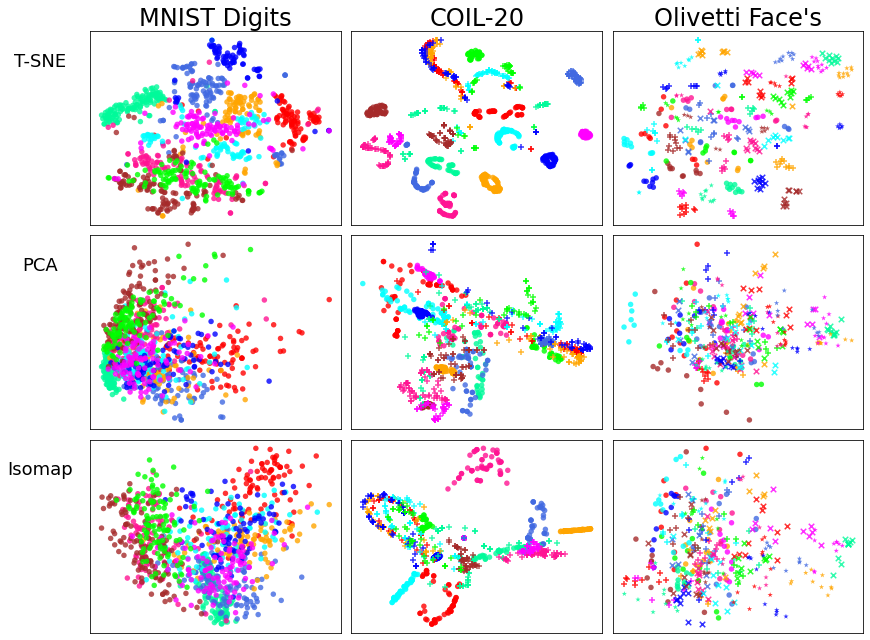

In [29]:
colors = ['red', 'mediumspringgreen', 'royalblue','orange' ,'deeppink',
          'aqua','blue', 'brown' ,'fuchsia', 'lime']
shapes = ['o', '+', 'x', '*', 'D', 'p']

fmt_list = [gen_fmt_dict(y, colors, shapes) for y in [ym, yc, yo]]

titles = ["MNIST Digits", "COIL-20", "Olivetti Face's"]
legends = [False, False, False]

compare_methods(data_list=[Xm, Xc, Xo], label_list=[ym, yc, yo], data_names=titles, 
            fmt_list=fmt_list, legends=legends, perplexity=40, n_neighbors=12, niter=2000)

In [20]:
Xcan, ycan = load_UCI()
Xm1, ym1   = load_humanM1(nrows=500)

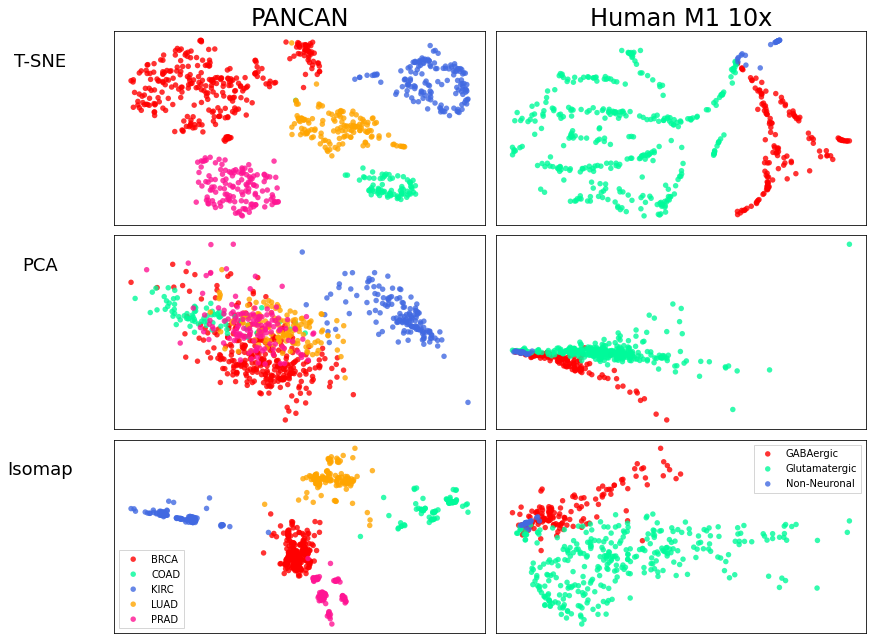

In [21]:
colors = ['red', 'mediumspringgreen', 'royalblue','orange' ,'deeppink',
          'aqua','blue', 'greenyellow' ,'fuchsia', 'lime']
shapes = ['o', '+', 'x', '*', 'D', 'p']

fmt_list = [gen_fmt_dict(y, colors, shapes) for y in [ycan, ym1]]

titles = ["PANCAN", "Human M1 10x"]
legends = [True, True]

compare_methods(data_list=[Xcan, Xm1], label_list=[ycan, ym1], data_names=titles, 
            fmt_list=fmt_list, legends=legends, niter=100)